NB : This is pure coding notebook. Markdowns are only written for the justification

In [60]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [61]:
spark = SparkSession.builder.appName("employee performance").getOrCreate()

In [62]:
data = spark.read.format("csv").option("inferSchema", True).option("header", True).load("../data/practice_dataset.csv")

data.show(5)

+----------+------------+------------+------------+------------+----------------+
|EmployeeID|        KPI1|        KPI2|        KPI3|        KPI4|Current Employee|
+----------+------------+------------+------------+------------+----------------+
|         0|-1.039682384|-0.716426478|-0.513467693| 0.414661471|               0|
|         1| 0.237093465|-0.820123996|-0.865801274| 0.438661047|               0|
|         2|-2.077948003| 0.185688029|-0.132418305| 0.711280402|               1|
|         3|-0.684711628| 1.522335039| 1.674082146|-1.234292085|               1|
|         4|-1.137117653|-0.555136531|-0.176780706|-1.776008972|               0|
+----------+------------+------------+------------+------------+----------------+
only showing top 5 rows


In [63]:
data.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- KPI1: double (nullable = true)
 |-- KPI2: double (nullable = true)
 |-- KPI3: double (nullable = true)
 |-- KPI4: double (nullable = true)
 |-- Current Employee: integer (nullable = true)



In [64]:
_ = f"Rows : {data.count()}, columns : {len(data.columns)}"
_

'Rows : 10000, columns : 6'

In [65]:
feature_columns = [col for col, typ in data.dtypes if typ=="double"]

feature_set = data.select(feature_columns).toPandas()
feature_set.head()

,KPI1,KPI2,KPI3,KPI4
0,-1.039682,-0.716426,-0.513468,0.414661
1,0.237093,-0.820124,-0.865801,0.438661
2,-2.077948,0.185688,-0.132418,0.711280
3,-0.684712,1.522335,1.674082,-1.234292
4,-1.137118,-0.555137,-0.176781,-1.776009


array([[<Axes: title={'center': 'KPI1'}>,
        <Axes: title={'center': 'KPI2'}>],
       [<Axes: title={'center': 'KPI3'}>,
        <Axes: title={'center': 'KPI4'}>]], dtype=object)

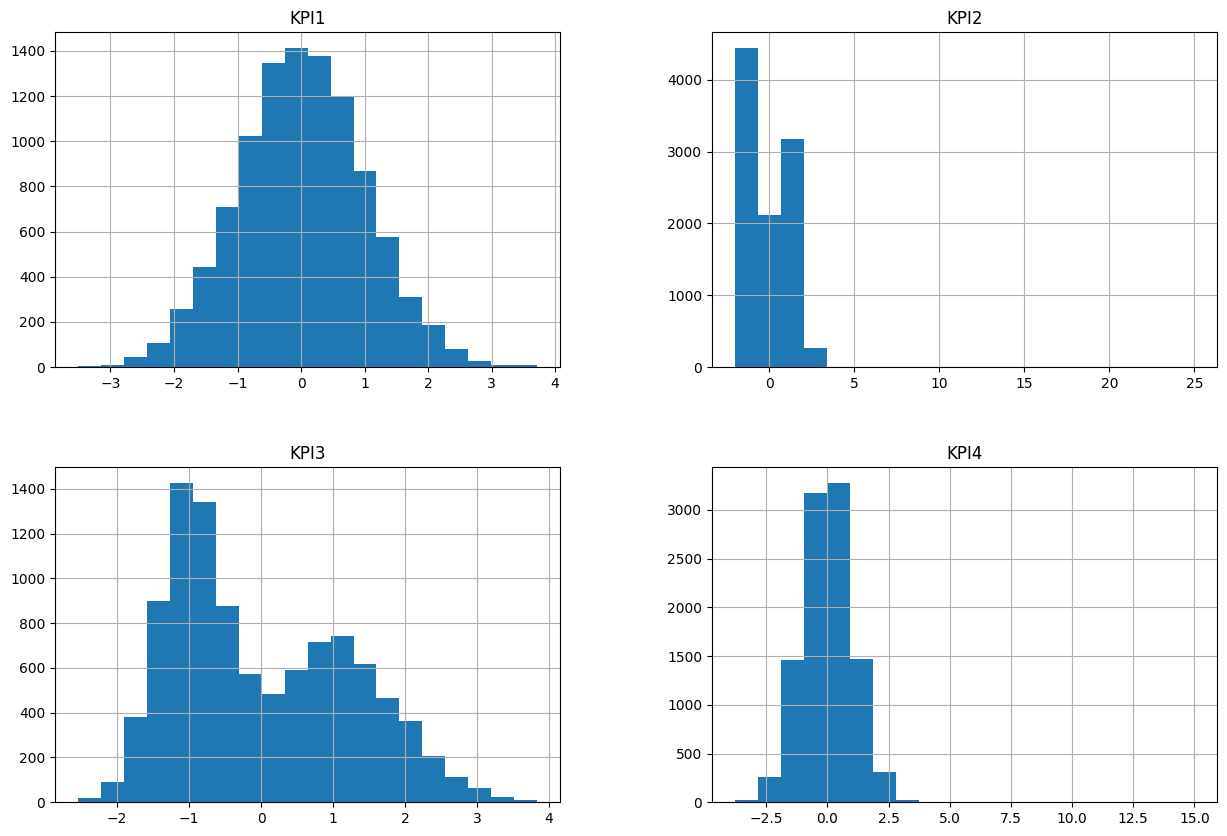

In [66]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
feature_set.hist(ax=ax, bins=20)

In [67]:
feature_set.corr()

,KPI1,KPI2,KPI3,KPI4
KPI1,1.000000,0.019028,0.018915,0.001397
KPI2,0.019028,1.000000,0.960970,-0.002108
KPI3,0.018915,0.960970,1.000000,-0.004496
KPI4,0.001397,-0.002108,-0.004496,1.000000


In [68]:
for column in feature_columns:
    data.select(count(when(col(column).isNull(), column)).alias(column)).show()

+----+
|KPI1|
+----+
|   4|
+----+

+----+
|KPI2|
+----+
|   0|
+----+

+----+
|KPI3|
+----+
|   2|
+----+

+----+
|KPI4|
+----+
|   3|
+----+



In [69]:
imputer = Imputer(inputCols=feature_columns, outputCols=feature_columns).setStrategy("mean")
imputer = imputer.fit(data)
data = imputer.transform(data)
for column in feature_columns:
    data.select(count(when(col(column).isNull(), column)).alias(column)).show()

+----+
|KPI1|
+----+
|   0|
+----+

+----+
|KPI2|
+----+
|   0|
+----+

+----+
|KPI3|
+----+
|   0|
+----+

+----+
|KPI4|
+----+
|   0|
+----+



In [ ]:
data = data.filter(data.KPI2<5).filter(data.KPI4<5)
data.select("*").where(data.KPI4 > 5).show()
# outlier is removed

+----------+----+----+----+----+----------------+
|EmployeeID|KPI1|KPI2|KPI3|KPI4|Current Employee|
+----------+----+----+----+----+----------------+
+----------+----+----+----+----+----------------+

